In [1]:
# importing packages
import pandas as pd
import numpy as np
import time
import qcodes as qc
import pyvisa as visa
import ipywidgets as widgets
# enable to get a more debuggable output:
#visa.log_to_screen()

# importing the instrument driver packages: 
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.tektronix.Keithley_2400 import Keithley_2400

# pyvisa-py resource manager
rm = visa.ResourceManager('@py')

print(rm)

Resource Manager of Visa Library at py


In [2]:
# list the resources that the visapy-py backend detects, should look something like:
# `('ASRL/dev/ttyS4::INSTR', 'USB0::2849::57::91LA25023::0::INSTR')`
resources = rm.list_resources()

# intialize the instrument with the following parameters:

# the instrument is initialized and stored as a variable gs, where "gs200" is its name
gs = GS200("gs200", address=resources[0], terminator="\n")

# the instrument is initialized and stored as a variable gs, where "keith" is its name
keith = Keithley_2400("keithley2400", address=resources[1])

libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid des

Connected to: YOKOGAWA GS210 (serial:91LA25023, firmware:1.05) in 0.18s
Connected to: KEITHLEY INSTRUMENTS INC. 2400 (serial:1371034, firmware:C32   Oct  4 2010 14:20:11/A02  /S/K) in 0.18s


In [3]:
station = qc.Station()

In [4]:
station.add_component(gs)
station.add_component(keith)

[gs200_program(GS200Program)] Snapshot: Could not update parameter: trigger


'keithley2400'

In [5]:
import numpy as np
import qcodes as qc
from qcodes.dataset import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)

## Dummy instruments for generating synthetic data
from qcodes.tests.instrument_mocks import (
    DummyInstrument, 
    DummyInstrumentWithMeasurement
)

## Multidimensional scanning module
from qcodes.utils.dataset.doNd import (
    dond, 
    LinSweep, 
    LogSweep
)

## Integrated plotting module
from qcodes.dataset.plotting import plot_dataset

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

In [6]:
gs.reset()
gs.source_mode('CURR')
gs.current(0)
gs.auto_range(True)
gs.output('on')

In [7]:
keith.reset()

In [8]:
# lower the compliance current all the way
#keith.mode('VOLT')
keith._set_mode_and_sense('CURR')
keith._set_mode_and_sense('VOLT')
keith.compliancei(1e-06)
keith.rangev(30)
#keith.sense()
keith.output(1)
# resetting the instrument

In [9]:
initialise_or_create_database_at("~/leds_actual.db")

In [16]:
leds_exp = load_or_create_experiment(
    experiment_name="leds_30mA",
    sample_name="red_led"
)

In [17]:
context_meas = Measurement(exp=leds_exp, name='context_example')

In [18]:
# Register the independent parameter...
context_meas.register_parameter(gs.current)
# ...then register the dependent parameter
context_meas.register_parameter(keith.volt, setpoints=(gs.current,))

In [19]:
# Setting up a doNd measurement
sweep_1 = LinSweep(gs.current, 0.00, 0.03, 300, 0.01)

In [20]:
gs.current(0)

dond(
    sweep_1,                          # 1st independent parameter
    keith.volt,                 # 1st dependent parameter
    measurement_name="red_diode",#ment name
    exp=leds_exp,             # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)

gs.current(0)

Starting experimental run with id: 6. Using 'qcodes.dataset.dond'


  0%|          | 0/300 [00:00<?, ?it/s]

(red_diode #6@/root/leds_actual.db
 ---------------------------------
 gs200_current - numeric
 keithley2400_volt - numeric,
 [None],
 [None])

In [21]:
experiments() 

[leds_exp#green_led#1@/root/leds_actual.db
 -----------------------------------------
 1-green_diode-1-gs200_current,keithley2400_volt-40,
 leds_exp#red_led#2@/root/leds_actual.db
 ---------------------------------------
 2-red_diode-1-gs200_current,keithley2400_volt-40,
 leds_30mA#red_led#3@/root/leds_actual.db
 ----------------------------------------
 3-red_diode-1-gs200_current,keithley2400_volt-600
 6-red_diode-2-gs200_current,keithley2400_volt-300,
 leds_30mA#green_led#4@/root/leds_actual.db
 ------------------------------------------
 4-green_diode-1-gs200_current,keithley2400_volt-600
 5-green_diode-2-gs200_current,keithley2400_volt-300]

In [25]:
red_dataset = load_by_run_spec(experiment_name='leds_30mA', captured_run_id=6)
red_dataset

red_diode #6@/root/leds_actual.db
---------------------------------
gs200_current - numeric
keithley2400_volt - numeric

In [26]:
green_dataset = load_by_run_spec(experiment_name='leds_30mA', captured_run_id=5)
green_dataset

green_diode #5@/root/leds_actual.db
-----------------------------------
gs200_current - numeric
keithley2400_volt - numeric

([<AxesSubplot:title={'center':'Run #5, Experiment leds_30mA (green_led)'}, xlabel='Current ($10^{-3}$ I)', ylabel='Voltage (V)'>],
 [None])

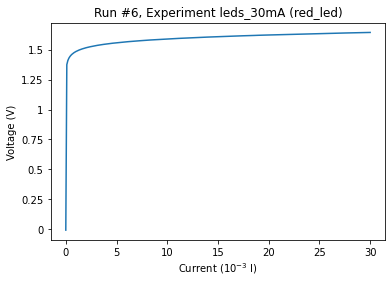

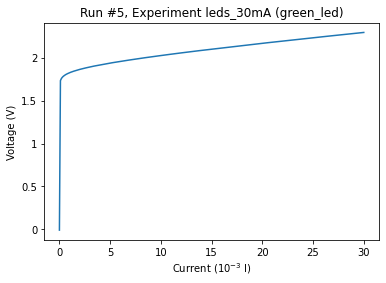

In [27]:
plot_dataset(red_dataset)
plot_dataset(green_dataset)

In [28]:
green_df = green_dataset.to_pandas_dataframe()
green_df.reset_index()[:1]

red_df = red_dataset.to_pandas_dataframe()
red_df.reset_index()[:1]

,gs200_current,keithley2400_volt
0,0.0,-0.00846


In [29]:
import matplotlib.pyplot as plt

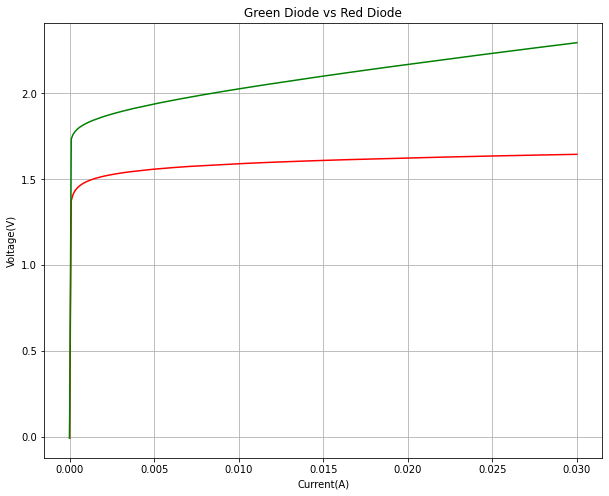

In [30]:
x_green = green_df.reset_index().loc[:,"gs200_current"]
y_green = green_df.reset_index().loc[:,"keithley2400_volt"]

x_red = red_df.reset_index().loc[:,"gs200_current"]
y_red = red_df.reset_index().loc[:,"keithley2400_volt"]

plt.figure(figsize=(10, 8))
ax = plt.axes()
#ax.scatter(x=x_green, y=y_green, color="green")
#ax.scatter(x=x_red, y=y_red, color="red")
ax.plot(red_df, color="red")
ax.plot(green_df, color = "green")

ax.set_xlabel('Current(A)')
ax.set_ylabel('Voltage(V)')

plt.grid()
plt.title("Green Diode vs Red Diode")

#plt.xlim([-0.001, 0.001])
plt.show()

In [ ]:
gs.reset()

In [ ]:
keith.reset()